# Proyecto Integrado 2

## Preparación de datos
  
### Inicializacion y carga de datos

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
# Primero cargamos las tablas
train_data = pd.read_csv('../datasets/gold_recovery_train.csv')
test_data = pd.read_csv('../datasets/gold_recovery_test.csv')
full_data = pd.read_csv('../datasets/gold_recovery_full.csv')

In [3]:
# Primero veamos la tabla train
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
# De ahi la tabla test
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [5]:
# Finalmente la tabla full
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Revisemos entonces como son los procesos de extraccion y aislacion del oro para poder entender un poco las tablas.

**1. Flotación**
  
La mezcla de mineral de oro se introduce en las plantas de flotación para obtener un concentrado de oro rougher y colas rougher (es decir, residuos del producto con una baja concentración de metales valiosos).
  
La estabilidad de este proceso se ve afectada por la volatilidad y el estado físico-químico desfavorable de la pulpa de flotación (una mezcla de partículas sólidas y líquido).
  
**2. Purificación**
El concentrado rougher se somete a dos etapas de purificación. Luego de esto, tenemos el concentrado final y las nuevas colas.
  
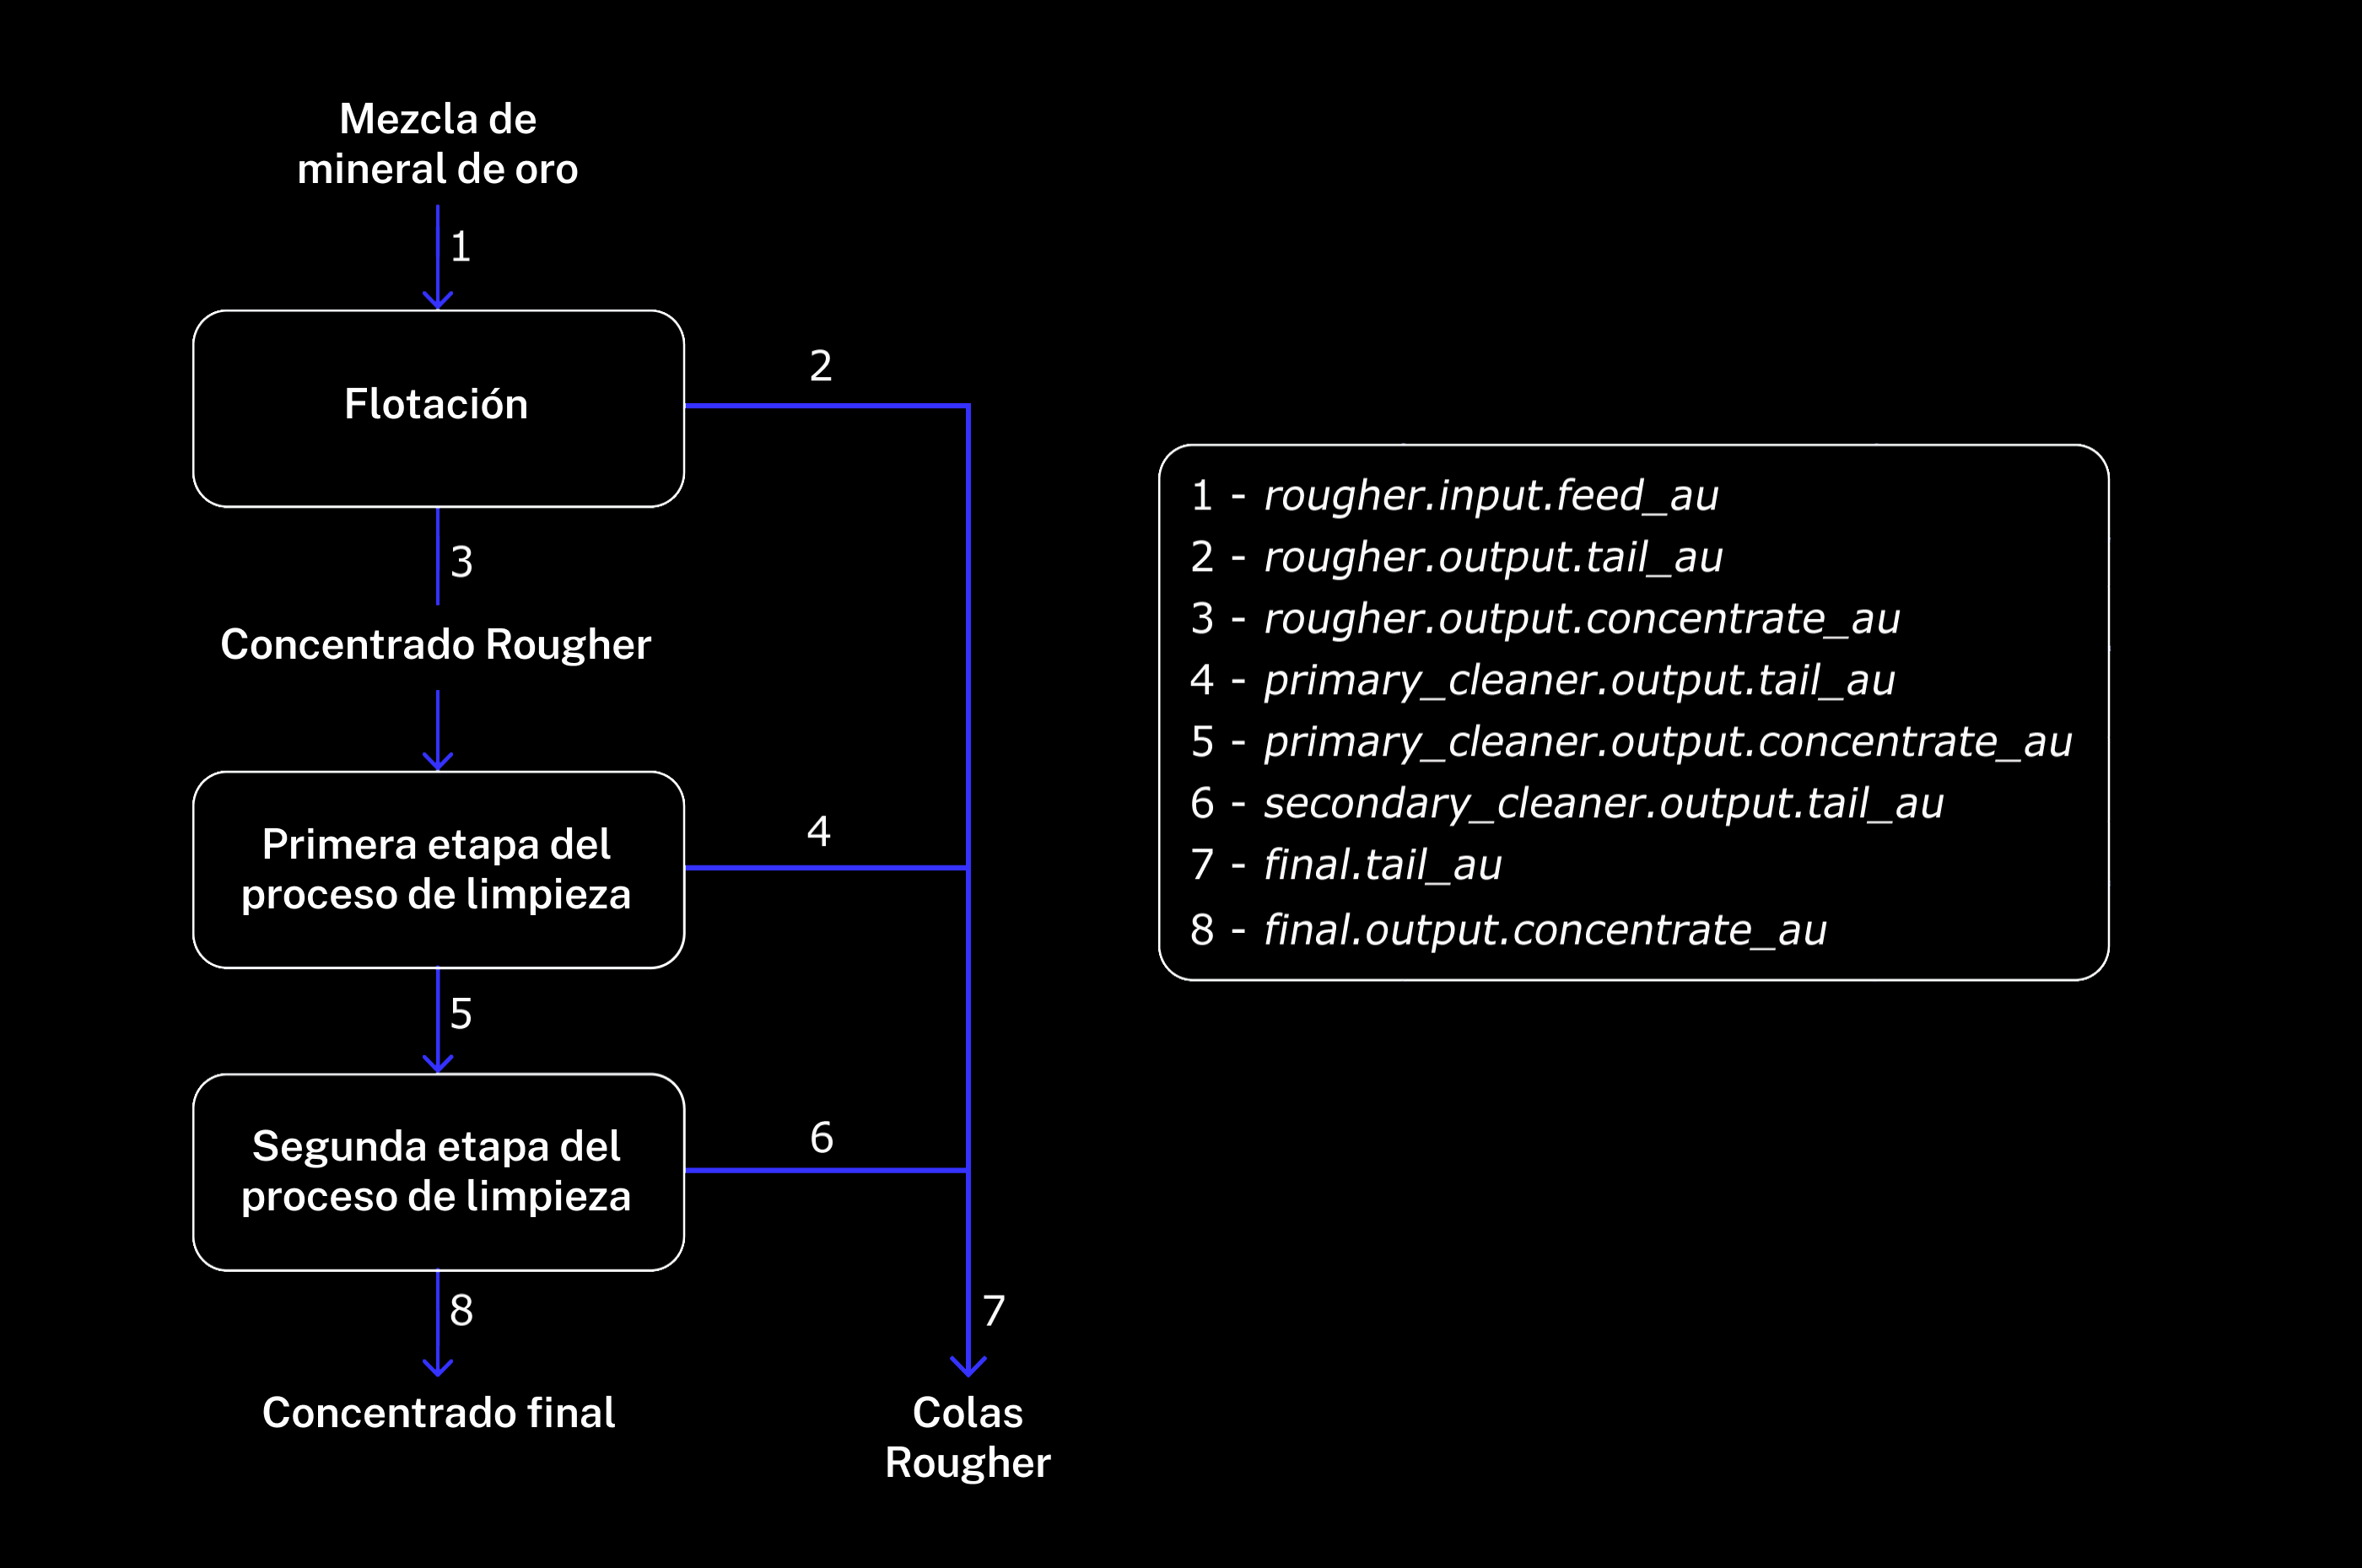

**Descripción de datos**
- Proceso tecnológico
    - Rougher feed — materia prima
    - Rougher additions (o adiciones de reactivos) - reactivos de flotación: xantato, sulfato, depresante
        - Xantato — promotor o activador de la flotación
        - Sulfato — sulfuro de sodio para este proceso en particular
        - Depresante — silicato de sodio
    - Rougher process — flotación
    - Rougher tails — residuos del producto
    - Float banks — instalación de flotación
    - Cleaner process — purificación
    - Rougher Au — concentrado de oro rougher
    - Final Au — concentrado de oro final
  
**Parámetros de las etapas**
   - air amount — volumen de aire
   - fluid levels — altura de las soluciones en el tanque
   - feed size — tamaño de las partículas de la alimentación
   - feed rate — tasa en la que se suministra material
  
**Denominación de las características**
  
*Así es como se denominan las características:*
  
`[stage].[parameter_type].[parameter_name]`
  
Ejemplo: `rougher.input.feed_ag`
  
**Valores posibles para [stage]:**
   - rougher — flotación
   - primary_cleaner — purificación primaria
   - secondary_cleaner — purificación secundaria
   - final — características finales
  
**Valores posibles para [parameter_type]:**
   - input — parámetros de la materia prima
   - output — parámetros del producto
   - state — parámetros que caracterizan el estado actual de la etapa
   - calculation — características de cálculo

### Verificación del cálculo de recuperación

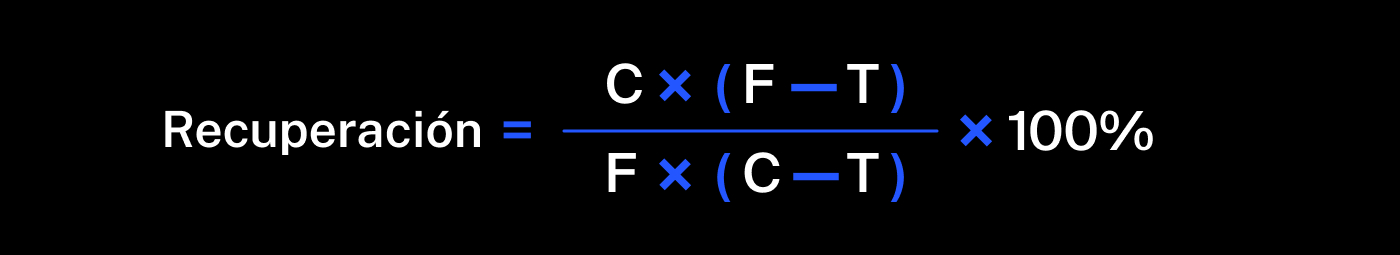
- **C —** proporción de oro en el concentrado justo después de la flotación (para saber la recuperación del concentrado rougher)/después de la purificación (para saber la recuperación del concentrado final)
- **F —** la proporción de oro en la alimentación antes de la flotación (para saber la recuperación del concentrado rougher)/en el concentrado justo después de la flotación (para saber la recuperación del concentrado final)
- **T —** la proporción de oro en las colas rougher justo después de la flotación (para saber la recuperación del concentrado rougher)/después de la purificación (para saber la recuperación del concentrado final)

Ahora vamos a buscar verificar que el cálculo de recuperación que tenemos en la tabla se haya hecho de manera correcta. Para eso vamos a realizar el cálculo con los valores que tenemos en la tabla y comparar por cuánto difieren con los valores que aparecen.

In [6]:
# Primero veamos cuales son las columnas que tienen los recovery
[c for c in train_data.columns if "recovery" in c]

['final.output.recovery', 'rougher.output.recovery']

In [7]:
# Veamos cuales son las columnas con rougher para realizar los calculos
[c for c in train_data.columns if 'rougher' in c]

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_l

In [8]:
# Entonces ahora definamos una funcion para realizar el cálculo
def recovery_calc(data, C_column, F_column, T_column):
    
    # Nos mantenemos ordenados separado por partes
    numerator = 100 * data[C_column] * (data[F_column] - data[T_column])
    denominator = data[F_column] * (data[C_column] - data[T_column])
    
    return numerator/denominator

In [9]:
# Ahora es cuestion de crear una columna con nuestra funcion
train_data["rougher.output.recovery_calculated"] = recovery_calc(
                                                train_data, 'rougher.output.concentrate_au','rougher.input.feed_au',
                                                'rougher.output.tail_au')

In [10]:
# Primero separamos los datos en los que los recovery de rougher no tienen nulo
train_data_without_nulls = train_data.loc[(train_data['rougher.output.recovery_calculated'].notna()) & 
                                          (train_data['rougher.output.recovery'].notna())]

In [11]:
# Ahora calculamos el EAM de los calculos
mean_absolute_error(train_data_without_nulls['rougher.output.recovery'],
                    train_data_without_nulls['rougher.output.recovery_calculated'])

1.1101950495226952e-14

Bueno, con 13 ceros despues de la coma podemos decir con bastante certeza de que no hay error en los cálculos de `rougher.output.recovery`. Entonces podemos pasar a la siguiente etapa!
  
### Análisis de características faltantes en `test_data`

In [12]:
# Primero veamos cuales son las columnas que tiene train_data y no test_data
set(train_data.columns) - set(test_data.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.recovery_calculated',
 'rougher.output.tail_ag',
 'rough

Si miramos el `parameter_type` en los nombres notamos como todas las columnas son `output` o `calculation`. Eso nos da una clara idea de que el proceso de purificacion del oro toma un cierto tiempo por lo que esos valores no eran posibles de obtener al momento de obtener los datos de la etapa `input`. Por otra parte, seguramente `calculation` son simplemente cálculos hechos con la ayuda de datos obtenidos de `output`.
  
A fin de cuentas, no hay ningun problema con que falten esas columnas ya que un modelo en producción no tendría acceso a esos valores al momento de realizar predicciones.

### Preprocesamiento de datos
  
Sabemos que tenemos datos ausentes, veamos entonces que proporcion de los datos estan faltando.

In [13]:
# Antes algo que quiero hacer es cambiar las columnas date en los datos a formate datetime
train_data['date'] = pd.to_datetime(train_data['date'], format='%Y-%m-%d %H:%M:%S')

In [14]:
# Ahora lo hacemos en test
test_data['date'] = pd.to_datetime(test_data['date'], format='%Y-%m-%d %H:%M:%S')

In [15]:
# Y finalmente lo hacemos en full
full_data['date'] = pd.to_datetime(full_data['date'], format='%Y-%m-%d %H:%M:%S')

In [16]:
# Creemos una funcion que nos resuma el impacto de simplemente borrar los nulos
def drop_na_summary(data):
    print(f'''Tamaño original: {data.shape[0]}
Tamaño sin nulos: {data.dropna(how='any').shape[0]}
Diferencia neta: {data.shape[0] - data.dropna(how='any').shape[0]}
Diferencia porcentual: {100*(data.shape[0]- data.dropna(how='any').shape[0])/data.shape[0]:.4f} %
''')

#### `train_data`

In [17]:
# Primero veamos las columnas con faltantes que nos interesan en train
train_data.isna().mean()[[c for c in test_data.columns if ('input' in c) or ('state' in c)]].sort_values(ascending=False)*100

rougher.input.floatbank11_xanthate            11.293001
primary_cleaner.input.sulfate                  7.752076
primary_cleaner.input.depressant               7.485172
rougher.input.floatbank10_sulfate              6.192171
primary_cleaner.input.xanthate                 5.842230
rougher.input.floatbank11_sulfate              3.695136
rougher.state.floatbank10_e_air                3.576512
rougher.input.feed_rate                        3.042705
rougher.input.feed_size                        2.473310
secondary_cleaner.state.floatbank2_a_air       2.153025
rougher.input.floatbank10_xanthate             2.052195
rougher.input.feed_sol                         1.731910
rougher.input.feed_pb                          1.352313
secondary_cleaner.state.floatbank2_b_air       0.919336
secondary_cleaner.state.floatbank4_a_air       0.765125
secondary_cleaner.state.floatbank3_a_level     0.670225
secondary_cleaner.state.floatbank4_a_level     0.670225
secondary_cleaner.state.floatbank2_b_level     0

En realidad, esas no son las únicas columnas que les faltan datos pero todas las demas tiene menos del 3,69% de datos faltantes. Por otra parte, si observamos bien podemos notar que las primeras 6 columnas que aparecen ahi son todas de `output` causando que la primera columna que nos interesa sea `rougher.input.floatbank11_xanthate` con un 11,29% de datos faltantes.
  
Despues de ponderar un rato, decidi que vamos a reemplazar los valores faltantes solo en las columnas pertinentes pero solo si tienen una cantidad de nulos superiores al 1%.

In [18]:
# Antes de realizar todo el trabajo, quiero ver cuantas filas perderia de eliminar todas las filas con nulos
drop_na_summary(train_data)

Tamaño original: 16860
Tamaño sin nulos: 11017
Diferencia neta: 5843
Diferencia porcentual: 34.6560 %



In [19]:
# Primero definimos las columnas que vamos a querer imputar
columns_to_fill = list(train_data.isna().mean()[[c for c in test_data.columns if ('input' in c) or ('state' in c)]]
                       .sort_values(ascending=False).head(13).index)

# De ahi creamos un DataFrame vacio
new_columns = pd.DataFrame([])

# Finalmente con un for creamos las tablas que nos digan cuando esa columna esta vacia
for column in columns_to_fill:
    new_columns[f'missing_{column}'] = train_data[column].isna()
    
# Y como detalle menor le cambiamos el dtype de las columnas a int
new_columns = new_columns.astype(int)

In [20]:
# Finalmente agregamos las columnas informativas al df y lo guardamos en una variable auxiliar
dummy_train_data = pd.concat([train_data,new_columns],axis=1)

In [21]:
# Ahora entonces reemplazamos los valores con la media de cada columna
for column in columns_to_fill:
    dummy_train_data.loc[(dummy_train_data[column].isna()),column] = dummy_train_data[column].mean()

In [22]:
# Verificamos si los cambios se hicieron
dummy_train_data[columns_to_fill].isna().sum()

rougher.input.floatbank11_xanthate          0
primary_cleaner.input.sulfate               0
primary_cleaner.input.depressant            0
rougher.input.floatbank10_sulfate           0
primary_cleaner.input.xanthate              0
rougher.input.floatbank11_sulfate           0
rougher.state.floatbank10_e_air             0
rougher.input.feed_rate                     0
rougher.input.feed_size                     0
secondary_cleaner.state.floatbank2_a_air    0
rougher.input.floatbank10_xanthate          0
rougher.input.feed_sol                      0
rougher.input.feed_pb                       0
dtype: int64

In [23]:
# Finalmente, descartamos el resto de las filas que tienen nulos
dummy_train_data.dropna().shape

(12044, 101)

In [24]:
# Veamos que porcentaje de filas perdimos
100 * (16860 - 12044) /16860

28.56465005931198

Okay... aca tenemos una situacion particular. Si decidimos imputar de la forma en la que dijimos ganamos un aproximado de 1000 filas en comparacion a si decidimos eliminar sin mas los nulos. Si tomamos en cuenta que vamos a tener datos que fueron agregados artificialmente y tambien notamos como tenemos 13 columnas mas de las cuales solo la minoria aportan informacion... Me parece que es una mejor idea simplemente eliminar las filas con nulos ya que la ganancia de imputar no es tan grande, menos tomando en cuenta que todos los posteriores datos de los que quieramos obtener una prediccion deberia tener esas 13 columnas (columnas que en un caso ideal no sirven para nada).

In [25]:
# Entonces simplemente las eliminemos
clean_train_data = train_data.dropna(how='any')

Otra opción que se puede tomar para los datos en concreto que nos encontramos es la de usar la función `ffill` que toma la última observación válida para reemplazar el valor nulo. En éste caso aprovechamos que toda la tabla tiene un orden temporal y asumimos que no hay diferencias muy significativas entre los valores obtenidos en fechas cercanas.

In [26]:
# Guardamos en otra variable para comparar despues
filled_train_data = train_data.ffill()

#### `test_data`

In [27]:
# Veamos las celdas faltantes
test_data.isna().mean().sort_values(ascending=False).head(15)*100

rougher.input.floatbank11_xanthate          6.028005
primary_cleaner.input.sulfate               5.157104
primary_cleaner.input.depressant            4.849727
rougher.input.floatbank10_sulfate           4.388661
primary_cleaner.input.xanthate              2.834699
rougher.input.floatbank10_xanthate          2.100410
rougher.input.feed_sol                      1.144126
rougher.input.floatbank11_sulfate           0.939208
rougher.input.feed_rate                     0.683060
secondary_cleaner.state.floatbank3_a_air    0.580601
secondary_cleaner.state.floatbank2_b_air    0.392760
rougher.input.feed_size                     0.375683
secondary_cleaner.state.floatbank2_a_air    0.341530
rougher.state.floatbank10_a_air             0.290301
rougher.state.floatbank10_c_air             0.290301
dtype: float64

En este caso podemos apreciar que los valores nulos con menos comunes que en la tabla de training. Eso es bueno ya que nos decidimos por crear un modelo el cual no tome columnas adicionales informando si una fila tenia nulo o no. De todas formas, veamos cuantas filas perdemos.

In [28]:
drop_na_summary(test_data)

Tamaño original: 5856
Tamaño sin nulos: 5383
Diferencia neta: 473
Diferencia porcentual: 8.0772 %



In [29]:
# Siendo que no perdemos tanto, podemos eliminar los nulos sin problema
clean_test_data = test_data.dropna(how='any')

In [30]:
# Repetimos el proceso con test
filled_test_data = test_data.ffill()

#### `full_data`

In [31]:
full_data.isna().mean().sort_values(ascending= False).head(15)

rougher.output.recovery                   0.137304
rougher.output.tail_ag                    0.120488
rougher.output.tail_au                    0.120444
rougher.output.tail_sol                   0.120444
rougher.input.floatbank11_xanthate        0.099357
secondary_cleaner.output.tail_sol         0.097508
final.output.recovery                     0.086415
rougher.calculation.au_pb_ratio           0.071624
primary_cleaner.input.sulfate             0.070831
primary_cleaner.input.depressant          0.068058
rougher.input.floatbank10_sulfate         0.057272
primary_cleaner.input.xanthate            0.050669
primary_cleaner.output.concentrate_sol    0.035129
rougher.input.floatbank11_sulfate         0.029847
rougher.state.floatbank10_e_air           0.027294
dtype: float64

In [32]:
drop_na_summary(full_data)

Tamaño original: 22716
Tamaño sin nulos: 16094
Diferencia neta: 6622
Diferencia porcentual: 29.1513 %



Tenemos menos nulos que en `train` pero más que en `test`... lo que tiene sentido ya que `full` contiene los datos de ambas tablas. Dado que no utilizaremos `full` para entrenar ni testear al modelo la vamos a dejar como está ya que los análisis que vamos a realizar no toman en cuenta los nulos.

## Analisis de datos
### Concentracion de metales según la etapa de purificación

In [33]:
# Primero repasemos las columnas que incluyen los metales
[c for c in train_data.columns if "_au" in c]

['final.output.concentrate_au',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.input.feed_au',
 'rougher.output.concentrate_au',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_au']

In [34]:
# Para poder visualizar esto, primero definimos lo siguiente
etapas = ['rougher.input.feed_','rougher.output.concentrate_','primary_cleaner.output.concentrate_','final.output.concentrate_']
metales = ["au","ag","pb"]

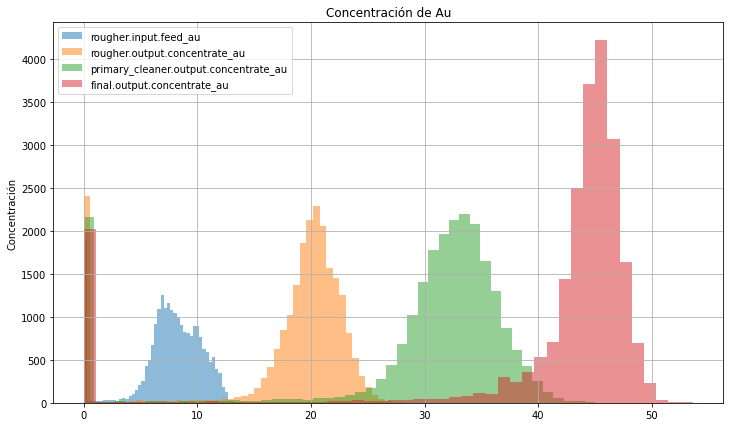

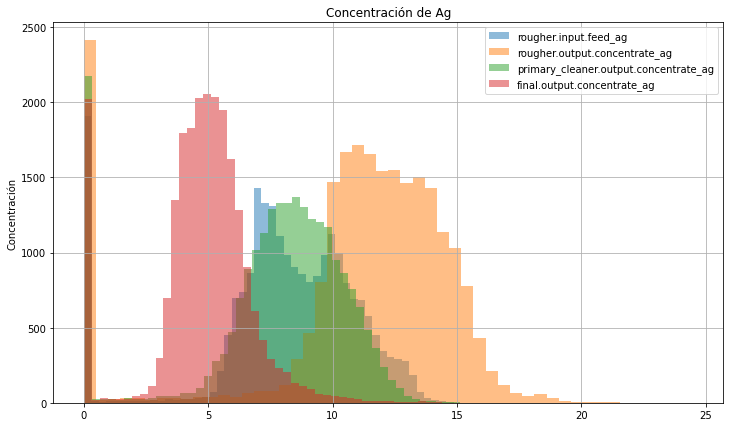

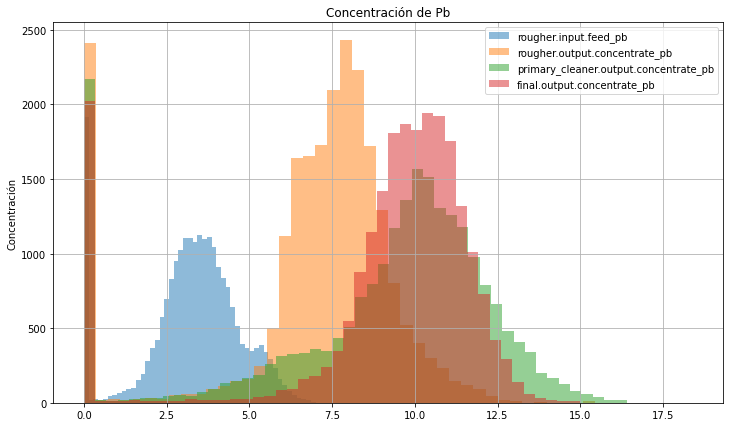

In [35]:
# Ahora grafiquemos, para eso vamos a circular sobre los metales y posteriormente sobre las etapas
for m in metales:
    for e in etapas:
        variable = e+m
        full_data[variable].hist(bins=50, alpha=0.5, label=variable, figsize=(12,7))

    plt.legend()
    plt.title(f"Concentración de {m.capitalize()}")
    plt.ylabel("Concentración")
    plt.show()

Antes de nada hay que destacar como en todos los metales en todas las etapas presentan concentraciones (no bajas) de valor 0, pero bueno supongo que a veces pasa simplemente que las mediciones dan así (o hubo un problema en los datos). Ahora, respecto a los datos que no son 0, analizemos metal por metal:
- Au (oro): podemos notar como la concentración de oro sube conforme avanzan las etapas con un salto bastante interesante hacia la última etapa. Tambien notamos como conforme avanzan las etapas baja gradualmente la varianza en los datos.
- Ag (plata): en el caso de la plata nos encontramos en una situacion diferente, podemos ver como la concentración más alta se encuentra en la etapa `rougher.output`, despues presenta concentraciones similares a la inicial y finalmente en la etapa final vemos como se concentra mucho mas y en valores más bajos.
- Pb (plomo): finalmente vemos como el plomo aumenta levemente a lo largo de las etapas y en la ultima etapa se concentra mas sobre un valor medio muy cercano al que tenia en la etapa anterior, pero con una menor varianza.
  
### Particulas de alimentación en `test_data` y `train_data`

Ahora vamos a ver como se distribuye el tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. Dado que debemos comparar las distribuciones de ambos datos, primero observamos los datos es con histogramas solapados pero normalizados.
  
Posteriormente vamos a realizar una prueba de hipótesis pero no sin antes determinar si las varianzas son diferentes con una prueba de Levene.

In [36]:
size_columns = ['rougher.input.feed_size','primary_cleaner.input.feed_size']

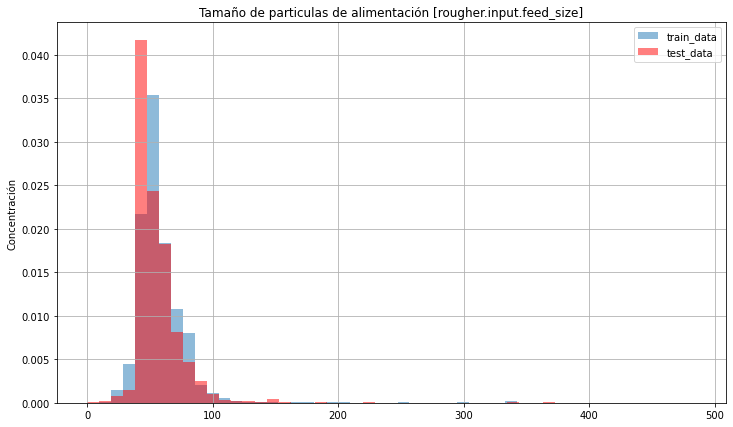

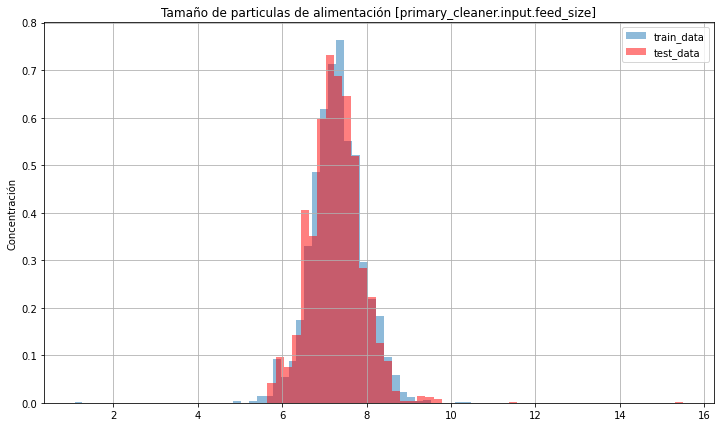

In [37]:
for column in size_columns:
    train_data[column].hist(bins=50, alpha=0.5, label='train_data', figsize=(12,7), density= True)
    test_data[column].hist(bins=50, alpha=0.5, label='test_data', figsize=(12,7), density= True, color= 'red')
    plt.legend()
    plt.title(f"Tamaño de particulas de alimentación [{column}]")
    plt.ylabel("Concentración")
    plt.show()

In [38]:
# Ahora vamos a realizar una prueba de hipótesis para comprobar si realmente los conjuntos varian significativamente

# Primero separmos los datos de train 
train_rougher_feed_size = train_data['rougher.input.feed_size'].dropna(how='any')
train_cleaner_feed_size = train_data['primary_cleaner.input.feed_size'].dropna(how='any')

# Y despues los de test
test_rougher_feed_size = test_data['rougher.input.feed_size'].dropna(how='any')
test_cleaner_feed_size = test_data['primary_cleaner.input.feed_size'].dropna(how='any')

In [39]:
# Pero antes vamos a realiar una prueba de Levene para determinar si las varianzas de los dos grupos son iguales o no
# Primero definimos el factor de significancia
alpha = 0.05

# Realizamos la prueba de Levene para los datos rouger y la guardamos
results = st.levene(test_rougher_feed_size, train_rougher_feed_size)

# Finalmente imprimimos el pvalue y el resultado de la prueba
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('Las varianzas son estadisticamente diferentes')
else:
    print("No podemos afirmar que las varianzas son estadisticamente diferentes")

p-value:  0.17579196524125687
No podemos afirmar que las varianzas son estadisticamente diferentes


En el caso de nuestras hipótesis son muy simples:
- *H0 (hipótesis nula): "El tamaño de las partículas entre las particulas de train y test no cambia"*
- *H1 (hipótesis alternativa): "El tamaño de las partículas entre las particulas de train y test cambia"*

In [40]:
# Con la prueba terminada y las varianzas determinadas como diferentes, vamos a proceder a evaluar las hipotesis
# Tomamos el alfa que dijimos previamente
alpha = 0.05

# Como sabemos que las varianzas no son diferentes en cada grupo, establecemos el parámetro equal_var como True
results = st.ttest_ind(test_rougher_feed_size, train_rougher_feed_size, equal_var=False)

# Finalmente vemos la respuesta que tanto buscamos
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('Rechazamos la hipótesis nula')
else:
    print("No rechazamos la hipótesis nula")

p-value:  6.7950959991986745e-15
Rechazamos la hipótesis nula


Al parecer nos encontramos en parte con una situación no del todo ideal, veamos si los datos del `primary_cleaner` comparten el problema o no.

In [41]:
# Pero antes vamos a realiar una prueba de Levene para determinar si las varianzas de los dos grupos son iguales o no
# Primero definimos el factor de significancia
alpha = 0.05

# Realizamos la prueba de Levene para los datos rouger y la guardamos
results = st.levene(test_cleaner_feed_size, train_cleaner_feed_size)

# Finalmente imprimimos el pvalue y el resultado de la prueba
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('Las varianzas son estadisticamente diferentes')
else:
    print("No podemos afirmar que las varianzas son estadisticamente diferentes")

p-value:  0.9052770087883676
No podemos afirmar que las varianzas son estadisticamente diferentes


In [42]:
# Con la prueba terminada y las varianzas determinadas como diferentes, vamos a proceder a evaluar las hipotesis
# Tomamos el alfa que dijimos previamente
alpha = 0.05

# Como sabemos que las varianzas no son diferentes en cada grupo, establecemos el parámetro equal_var como True
results = st.ttest_ind(test_cleaner_feed_size, train_cleaner_feed_size, equal_var=False)

# Finalmente vemos la respuesta que tanto buscamos
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('Rechazamos la hipótesis nula')
else:
    print("No rechazamos la hipótesis nula")

p-value:  0.0004554672200801049
Rechazamos la hipótesis nula


Como podemos ver, tanto en los datos de `rougher` como los de `primary_cleaner` presentan diferencias significativas entre los datos de `train` y `test`. Lamentablemente eso impactará sobre la evaluación del modelo y posiblemente sobre una puesta en producción en el peor de los casos.
  
Cabe destacar que la prueba T de Student que usamos nos permite comparar dos distribuciones más alla de si los conjuntos son iguales o muy diferentes en la cantidad total de datos. Eso es la kryptonita de nuestra situación ya que justo ahora nos encontramos comparando dos conjuntos de datos que difieren altamente en la cantidad total de datos. 
  
Para eso vamos a llamar otra prueba estadística no paramétrica, la prueba U de Mann-Whithney. Cumplimos con las dos condiciones requeridas de la prueba:
1. Independencia de las muestras: Tenemos confianza de eso ya que sabemos que los datos de ambas tablas difieren en días por lo tanto difieren en los lotes de material. Por otra parte tenemos las prubas que hicimos más arriba para darnos un poco más de confianza en que se cumple la condición.
2. Escala Ordinal: el tamaño de las particulas corresponden a una medida real que se puede categorizar en base a la relación de las diferentes medidas.
  
Con eso cumplido, podemos avanzar a realizar la prueba que para nuestra suerte forma parte de la librería de Scipy.

In [43]:
# Definimos el alpha como siempre
alpha = 0.05

# Ahora reai=lizamos la utest aclarando esos dos paramtros
results = st.mannwhitneyu(
    train_rougher_feed_size, test_rougher_feed_size, alternative='two-sided', method='auto')

# Veamos el pvalue
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('Rechazamos la hipótesis nula')
else:
    print("No rechazamos la hipótesis nula")

p-value:  2.0607012173612447e-67
Rechazamos la hipótesis nula


In [44]:
# Pasamos al otro par de conjuntos, no es necesario aclarar el alpha de unuevo
results = st.mannwhitneyu(
    test_cleaner_feed_size, train_cleaner_feed_size, alternative='two-sided', method='auto')

# Veamos el pvalue
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('Rechazamos la hipótesis nula')
else:
    print("No rechazamos la hipótesis nula")

p-value:  1.5814305158456248e-05
Rechazamos la hipótesis nula


Bueno, al parecer a la prueba de U no le parece que los conjuntos sean similares. Tambien cabe destacar que una prueba no paramétrica es más robusta pero menos precisa, en nuestro caso el conjunto de datos no son exactamente una distribución normal por lo cual en teoria algo como una prueba T no debería funcionar, pero posee una similaridad suficiente como para arrojar resultados respetables.
  
Al final de cuentas, no logramos superar completamente el problema de desbalance del tamaño de muestras pero con una prueba adicional reforzamos un poco la conclusión previamente obtenida. Siempre se puede realizar 1001 pruebas estadísticas pero hoy nuestro objetivo principal no es contestar ésta pregunta, así que sigamos con nuestro trabajo en mente. 

### Concentraciones a lo largo de las etapas

Ahora vamos a observar las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final. Nuestro foco en éste case es buscar valores anómalos y según cuántos encontremos decidiremos si los eliminamos o no.

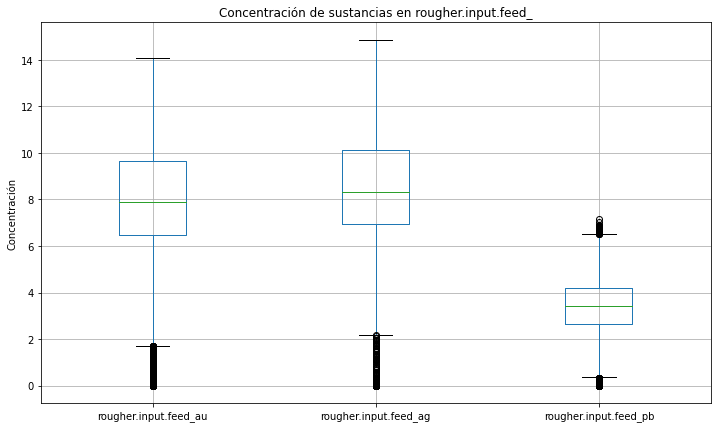

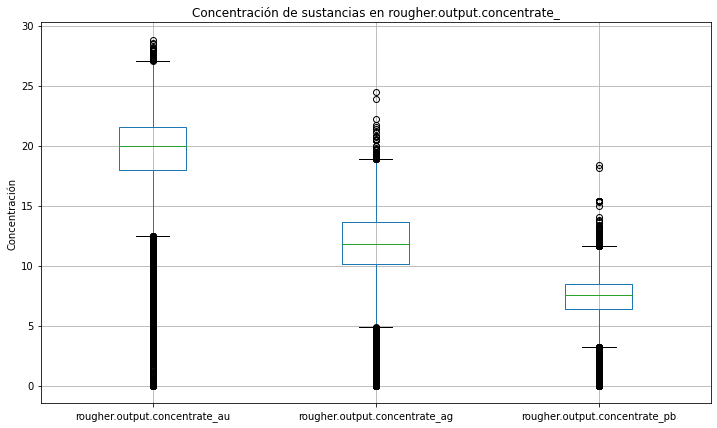

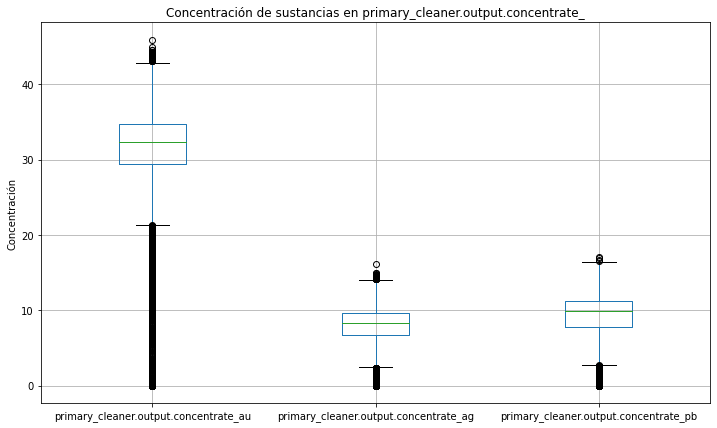

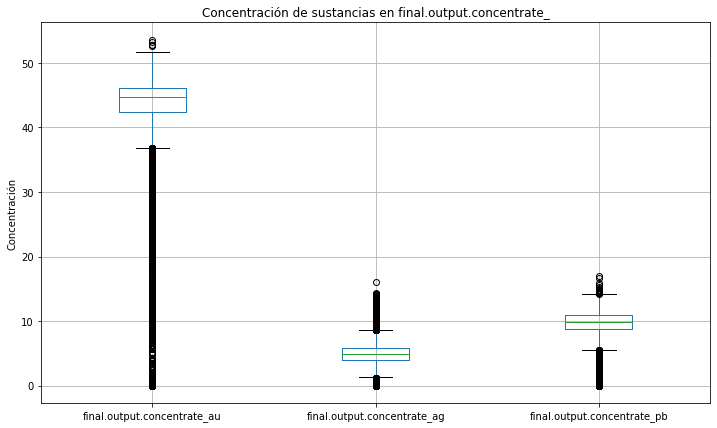

In [45]:
# Para realizar el analisis tenemos que llamar una vez mas a nuestro amigo, el bucle for
for e in etapas:
    variables = [e + me for me in metales]
    full_data.boxplot(column=variables, figsize=(12,7))
    

    plt.title(f"Concentración de sustancias en {e}")
    plt.ylabel("Concentración")
    plt.show()

Al parecer nos encontramos con su buena cantidad de valores anomalos, en todas las etapas en todos los concentrados. Supongo entonces que hay que mirar mas de cerca cuantos son esos puntos negros (o ya le diria lineas).

In [46]:
# Para el estudio de estos valores outliers vamos a traer una funcion
def remove_outliers(df,column:str): # Como podemos ver, debemos entregar el DataFrame y la columna a modificar
    
    # Primero determinamos la media y la desv. estandar
    mean =  df[column].mean()
    std = df[column].std()
    
    # Despues determinamos el z-score aprovechando la vectorizacion
    z_scores = ((df[column] - mean)/std).abs()
    
    # De ahi, si queremos eliminar los outliers nos quedamos solo con los menores e iguales a 3
    corrected_map = z_scores<=3
    
    # Finalmente filtramos el df con el mapa que tenemos
    corrected_df = df[corrected_map]
    
    # Y devolvemos el nuevo df [Nota: hay que reemplazar manualmente, no es inplace]
    return corrected_df

In [47]:
# Por otra parte, vamos a hacer una funcion que obtenga los outliers con el IQR
def remove_outliers_2(data,column:str):
    
    # Primero definimos los cuartiles 1 y 3
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    # De ahi definimos el IQR 
    IQR = Q3 - Q1
    
    # Ahora encontramos los límites superiores e inferiores
    upp_lim = 1.5*IQR + Q3
    low_lim = 1.5*IQR - Q1
    
    # Obtenemos un filtro para conseguir las filas outliers
    mapper = ((data[column] >= Q1 - 1.5 * IQR) & (data[column] <= Q3 + 1.5 *IQR))
    
    # Y finalmente creamos la tabla con outliers
    outlier_data = data.loc[mapper]
    
    return outlier_data

In [48]:
# Y tambien realizamos la funcion inversa a la anterior
def get_outliers(df,column:str):
    
    # Primero determinamos la media y la desv. estandar
    mean =  df[column].mean()
    std = df[column].std()
    
    # Despues determinamos el z-score aprovechando la vectorizacion
    z_scores = ((df[column] - mean)/std).abs()
    
    # De ahi, si queremos obtener los outliers nos quedamos solo con los mayores a 3
    corrected_map = z_scores>3
    
    # Finalmente filtramos el df con el mapa que tenemos
    corrected_df = df[corrected_map]
    
    # Y devolvemos el nuevo df [Nota: hay que reemplazar manualmente, no es inplace]
    return corrected_df

In [49]:
# Por otra parte, vamos a hacer una funcion que obtenga los outliers con el IQR
def get_outliers_2(data,column:str):
    
    # Primero definimos los cuartiles 1 y 3
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    # De ahi definimos el IQR 
    IQR = Q3 - Q1
    
    # Ahora encontramos los límites superiores e inferiores
    upp_lim = 1.5*IQR + Q3
    low_lim = 1.5*IQR - Q1
    
    # Obtenemos un filtro para conseguir las filas outliers
    mapper = ~((data[column] >= Q1 - 1.5 * IQR) & (data[column] <= Q3 + 1.5 *IQR))
    
    # Y finalmente creamos la tabla con outliers
    outlier_data = data.loc[mapper]
    
    return outlier_data

In [50]:
# Ahora es cuestion de ver cuantos valores quedan en nuestras tablas
print(f'Tamaño del dataset con outliers: {full_data.shape[0]} \n')

# Creamos una variable para poder ver de cuanto seria la pérdida máxima en el caso de que no haya solapamiento de los outliers
total_loss = 0

# Ahora con un bucle igual al de antes podemos ver en más detalle
for e in etapas:
    for m in metales:
        
        # Con un fstring vemos claramente cuantas filas nos quedan y cuantas perdemos
        print(f'''Tamaño del dataset sin outliers en la columna {e+m}: {remove_outliers(full_data,e+m).shape[0]}
 - Cantidad de filas perdidas: {full_data.shape[0] - remove_outliers(full_data,e+m).shape[0]}
        ''')
        
        # No nos olvidemos de sumar
        total_loss += full_data.shape[0] - remove_outliers(full_data,e+m).shape[0]

print('Perdida máxima de filas:', total_loss)    

Tamaño del dataset con outliers: 22716 

Tamaño del dataset sin outliers en la columna rougher.input.feed_au: 22617
 - Cantidad de filas perdidas: 99
        
Tamaño del dataset sin outliers en la columna rougher.input.feed_ag: 22618
 - Cantidad de filas perdidas: 98
        
Tamaño del dataset sin outliers en la columna rougher.input.feed_pb: 22472
 - Cantidad de filas perdidas: 244
        
Tamaño del dataset sin outliers en la columna rougher.output.concentrate_au: 22618
 - Cantidad de filas perdidas: 98
        
Tamaño del dataset sin outliers en la columna rougher.output.concentrate_ag: 22617
 - Cantidad de filas perdidas: 99
        
Tamaño del dataset sin outliers en la columna rougher.output.concentrate_pb: 22603
 - Cantidad de filas perdidas: 113
        
Tamaño del dataset sin outliers en la columna primary_cleaner.output.concentrate_au: 22618
 - Cantidad de filas perdidas: 98
        
Tamaño del dataset sin outliers en la columna primary_cleaner.output.concentrate_ag: 22618


Bueno, al parecer el Pb(plomo) presenta la mayor cantidad de outliers en casitodas las etapas exceptuando en el output final en donde los valores del Pb son "normales" mientras que Ag(plata) se destaca por encima con 194 valores anómalos.
  
Cabe destacar que la pérdida máxima de filas justamente contempla la situación en la que no haya un solapamiento de valores anomalos en una fila, o dicho de otra forma, que ninguno de los valores anómalos de una columna coincida con los valores anómalos de otras columnas en la misma fila.
  
Al parecer no tenemos tantos outliers, pero por más que sean pocos quizas algún patrón se encuentra escondido entre esas filas. Llamemos nuestras funciones y veamos más de cerca que sucede.

Ahora voy a realizar el mismo estudio pero con la función `outliers_2` que utiliza IQR.

In [51]:
# Ahora es cuestion de ver cuantos valores quedan en nuestras tablas con el otro metodo
print(f'Tamaño del dataset con outliers: {full_data.shape[0]} \n')

# Creamos una variable para poder ver de cuanto seria la pérdida máxima en el caso de que no haya solapamiento de los outliers
total_loss = 0

# Ahora con un bucle igual al de antes podemos ver en más detalle
for e in etapas:
    for m in metales:
        
        # Con un fstring vemos claramente cuantas filas nos quedan y cuantas perdemos
        print(f'''Tamaño del dataset sin outliers en la columna {e+m}: {remove_outliers_2(full_data,e+m).shape[0]}
 - Cantidad de filas perdidas: {full_data.shape[0] - remove_outliers_2(full_data,e+m).shape[0]}
        ''')
        
        # No nos olvidemos de sumar
        total_loss += full_data.shape[0] - remove_outliers_2(full_data,e+m).shape[0]

print('Perdida máxima de filas:', total_loss)    

Tamaño del dataset con outliers: 22716 

Tamaño del dataset sin outliers en la columna rougher.input.feed_au: 20584
 - Cantidad de filas perdidas: 2132
        
Tamaño del dataset sin outliers en la columna rougher.input.feed_ag: 20648
 - Cantidad de filas perdidas: 2068
        
Tamaño del dataset sin outliers en la columna rougher.input.feed_pb: 20464
 - Cantidad de filas perdidas: 2252
        
Tamaño del dataset sin outliers en la columna rougher.output.concentrate_au: 19700
 - Cantidad de filas perdidas: 3016
        
Tamaño del dataset sin outliers en la columna rougher.output.concentrate_ag: 19915
 - Cantidad de filas perdidas: 2801
        
Tamaño del dataset sin outliers en la columna rougher.output.concentrate_pb: 19722
 - Cantidad de filas perdidas: 2994
        
Tamaño del dataset sin outliers en la columna primary_cleaner.output.concentrate_au: 19829
 - Cantidad de filas perdidas: 2887
        
Tamaño del dataset sin outliers en la columna primary_cleaner.output.concentrat

La situación es muy diferente si usamos el IQR para reconocer outliers ya que no hay un solo elemento que presente una presencia superior de *outliers* (como el Pb en el caso anterior) y como vimos antes, notamos que en éste caso si o si hay solapamiento de valores ya que la pérdida máxima de filas supera a la cantidad total de filas que tenemos.
  
Ahora vamos a avanzar a la siguiente etapa y observar realmente cuántas filas se pierden con cada método y que caracterizan a éstas filas.

In [52]:
# Primero creamos las variables vacías
outliers = pd.DataFrame()
outliers_2 = pd.DataFrame()

# De ahí con dos bucles podemos obtener los outliers de las columnas que venimos estudiando
for e in etapas:
    for m in metales:
        outliers = pd.concat([outliers, get_outliers(full_data,e+m)])
        outliers_2 = pd.concat([outliers_2, get_outliers_2(full_data, e+m)])
        
        
# Y ahora tenemos que eliminar duplicados ya que nuestra forma no es perfecta, y reiniciamos el indice para dejar todo limpio
outliers.drop_duplicates(inplace= True)
outliers.reset_index(inplace= True, drop= True)

outliers_2.drop_duplicates(inplace= True)
outliers_2.reset_index(inplace= True, drop= True)

In [53]:
# Veamos entonces el tamaño de las tablas con outliers
print(f'''
Cantidad de outliers con z-score: {outliers.shape[0]}
Cantidad de outliers con IQR: {outliers_2.shape[0]}
''')


Cantidad de outliers con z-score: 121
Cantidad de outliers con IQR: 5346



Al parecer el método de IQR agarró mucho más valores como outliers que el método z-score. Eso explica la diferencia que sospechaba de nuestro análisis anterior y el gráfico `boxplot` siendo que éste utiliza el IQR para discriminar los *outliers*. 
De todas formas, es evidente la solapación previamente mencionada. Por otra parte, quiero observar bien la presencia de nulos en éstas tablas.

In [54]:
print(f''' Cantidad total de celdas nulas

Full Data: {full_data.isna().sum().sum()}
Outliers 1 (z-score): {outliers.isna().sum().sum()}
Outliers 2 (IQR): {outliers_2.isna().sum().sum()}
''')

 Cantidad total de celdas nulas

Full Data: 36587
Outliers 1 (z-score): 492
Outliers 2 (IQR): 31937



Cabe destacar que lo que busqué contabilizar es la cantidad de celdas nulas **totales**. Y lo que uno encuentra! Al parecer los outliers destacados por el rango IQR cubren la gran mayoría de los nulos **en la tabla**, siendo que solo alrededor de 4000 celdas no se encuentran. 
  
Eso nos da un indicio de que lo más probable es que si una fila tiene valores nulos tambien tenga outliers, puede ser que no es que se registraron valores extraños en el proceso del material sino que hubo un problema en el registro de dichas filas.
  
Con esos conocimientos puedo predecir que la pérdida de filas será mucho menor en las tablas de nuestros datos ya limpiados de nulos, y lamentablemente condena a una presencia mayor de outliers a las tablas sobre las cuales se les imputaron valores a los nulos.
  
*Entonces, llega la duda. Usamos el metodo z-score o el IQR para eliminar los outliers?*
  
Gracias a las revelaciones que nos dió el método IQR sabemos que la mayoría de los valores anómalos son aledaños a valores nulos por lo que no debemos esperar una gran presencia de outliers en las tablas `clean`. También sabemos que el método IQR eliminaría una grán cantidad de valores anómalos, aunque muchos de ellos fueron elimninados también en las tablas `clean`.
  
Entonces finalmente voy a decidir tomar el método z-score ya que deseo preservar la mayor cantidad de información posible.

In [55]:
# Ahora simplemente hay que eliminar los outliers en las tablas train y test
# Para eso primero creamos las variables como las tablas
targetless_test_data = clean_test_data
final_train_data = clean_train_data

# De ahi usamos un bucle ya que test solo tiene una de las etapas para ir eliminando outliers de las diferentes columnas
for m in metales:
    targetless_test_data = remove_outliers(targetless_test_data,'rougher.input.feed_'+m)
        
# En el caso de train necesitamos 2 bucles para eliminar los outliers antes mencionados
for e in etapas:
    for m in metales:
        final_train_data = remove_outliers(final_train_data,e+m)
        
# Finalmente reiniciamos los índices
targetless_test_data.reset_index(inplace= True)
final_train_data.reset_index(inplace= True)    

In [56]:
print(f'''
Filas en test sin outliers: {targetless_test_data.shape[0]}
Filas en test con outliers: {clean_test_data.shape[0]}

Filas en train sin outliers: {final_train_data.shape[0]}
Filas en train con outliers: {clean_train_data.shape[0]}
''')


Filas en test sin outliers: 5310
Filas en test con outliers: 5383

Filas en train sin outliers: 10053
Filas en train con outliers: 11017



Como podemos ver, efectivamente la pérdida no fue muy grande en ninguno de los dos conjuntos de datos. Eso es la prueba final de que efectivamente los outliers estaban mayormente vinculados a los valores nulos, supongo que habrá que enviar un feedback con las filas con nulos para que se realice un backtrack utilizando las fechas como referencia y analizar que sucedió en esos casos.

## Construcción del modelo
  
Ahora vamos a pasar a la construccion de nuestro modelo, para eso primero tenemos que definir cuales serán las features y los targets.
  
Uno de los detalles de los modelos que vamos a entrenar es que van a tener 2 targets, eso practicamente elimina el modelo de regresión lineal ya que éste puede tener 2 targets por lo que para éste trabajo deberíamos hacer 2 modelos diferentes.

In [57]:
# Los targets son simples, cuanto oro rougher y final recuperamos  
targets = ['rougher.output.recovery', 'final.output.recovery']

# Por su parte, las features las vamos a obtener en base a test_data
features = test_data.drop(columns=["date"]).columns.values



Para evaluar nuestro modelo usaremos una métrica particular llamada sMAPE (symmetric Mean Absolute Percentage Error)  
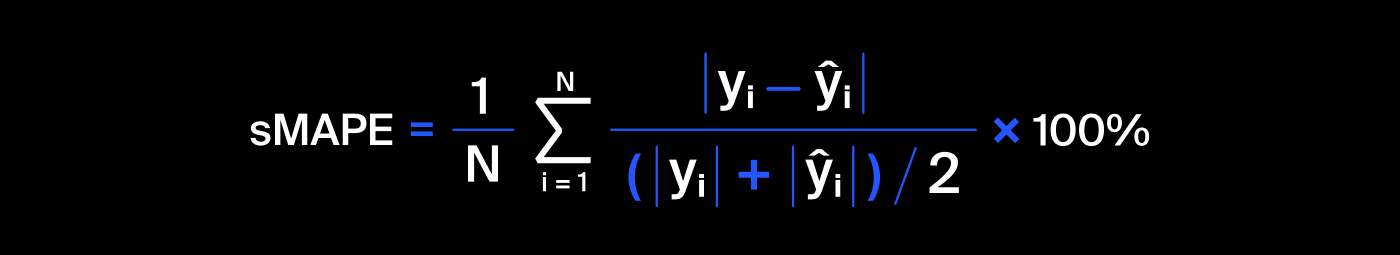
  
Asi que antes de hacer nada, hagamos una funcion que nos devuelva el sMAPE

In [58]:
# Primero creamos la funcion en cuestion, y le agregamos el **kwargs para poder crear un scorer posteriormente
def smape(y, y_pred, **kwargs):
    
    # Entonces solo es cuestion de crear variables con los nombres de lo que vemos en la fórmula
    n = len(y)
    abs_y = abs(y)
    abs_y_pred = abs(y_pred)
    abs_diff = abs(y - y_pred)
    
    # Y devolver la fórmula
    return 100*(2/n) * np.nansum(abs_diff / (abs_y + abs_y_pred))

El detalle, es que no tenemos que evaluar exactamente con esa métrica, sino con una versión ponderada específicamente para el cliente según la etapa:
  
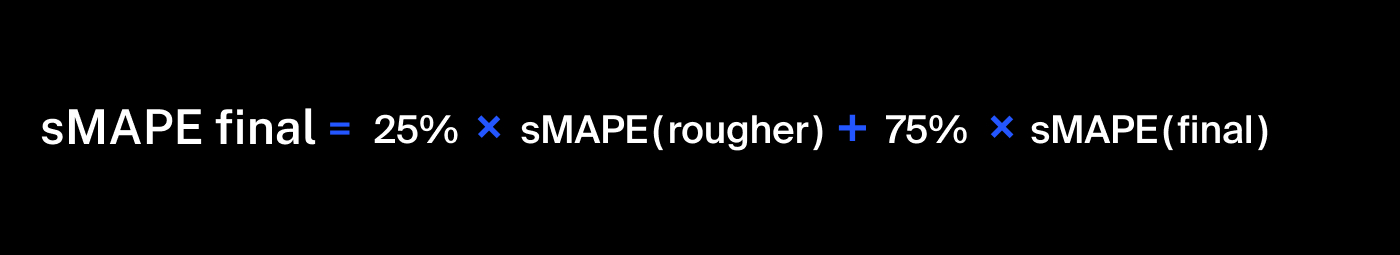

In [59]:
# Entonces simplemente creamos otra funcion para obtener esos valores
def smape_final(y, y_pred):
    # Antes que nada nos aseguramos de estar trabajando on arrays
    y = np.array(y)
    y_pred = np.array(y_pred)
    
    # De ahi obtenemos las predicciones de rougher y final
    pred_target_1 = y_pred[:, 0]
    pred_target_2 = y_pred[:, 1]
    
    # Despues obtenemos n
    n = y.shape[0]
    
    # Obtenemos los diferentes terminos de rougher_smape
    rougher_abs_y = abs(y[:, 0])
    rougher_abs_y_pred = abs(pred_target_1)
    rougher_abs_diff = abs(rougher_abs_y - rougher_abs_y_pred)
    
    # Y calculamos rougher_smape
    rougher_smape = 100*(2/n) * np.nansum(rougher_abs_diff / (rougher_abs_y + rougher_abs_y_pred))
    
    # Ahora se repite el proceso para obtener final_smape
    final_abs_y = abs(y[:, 1])
    final_abs_y_pred = abs(pred_target_2)
    final_abs_diff = abs(final_abs_y - final_abs_y_pred)
    final_smape = 100*(2/n) * np.nansum(final_abs_diff / (final_abs_y + final_abs_y_pred))
    
    # Finalmente devolvemos acorde al ponderado que nos piden
    return 0.25*rougher_smape + 0.75*final_smape

In [60]:
# Entonces creamos las tablas con las features y los targets para entrenar el modelo
features_train = final_train_data[features]
target_train = final_train_data[targets]

In [61]:
# Antes de entrenar un modelo tenemos que crear un scorer para la funcion searchCV
smape_scorer = make_scorer(smape_final, greater_is_better=False)

In [62]:
# Ahora vamos a crear el objeto search
forest_regressor_search = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions = {
        'n_estimators': [10, 20, 30],
        'max_depth': [3, 5, 7],
        'min_samples_split': [10, 50, 100]
    },
    n_iter = 5,
    scoring = smape_scorer,
    cv = 5,
    random_state = 96569)

In [63]:
# Ahora pasamos a entrenar el search
forest_regressor_search.fit(features_train, target_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'min_samples_split': [10, 50, 100],
                                        'n_estimators': [10, 20, 30]},
                   random_state=96569,
                   scoring=make_scorer(smape_final, greater_is_better=False))

In [64]:
# Entonces, cual es el mejor modelo que pudo conseguir el search?
forest_regressor_search.best_estimator_

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=30)

In [65]:
# Veamos tambien el sMAPE final que obtuvo
forest_regressor_search.best_score_

-7.726574932381946

In [66]:
# Ahora vamos a realizar otra busqueda de hiperparámetros pero con valores más cercanos a los obtenidos anteriormente
forest_regressor_search_2 = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions = {
        'n_estimators': [15, 20, 25],
        'max_depth': [4, 5, 6],
        'min_samples_split': [100, 125, 150]
    },
    n_iter = 5,
    scoring = smape_scorer,
    cv = 5,
    random_state = 96569)

In [67]:
# Entrenamos el nuevo search
forest_regressor_search_2.fit(features_train, target_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': [4, 5, 6],
                                        'min_samples_split': [100, 125, 150],
                                        'n_estimators': [15, 20, 25]},
                   random_state=96569,
                   scoring=make_scorer(smape_final, greater_is_better=False))

In [68]:
# Será diferente el nuevo modelo?
forest_regressor_search_2.best_estimator_

RandomForestRegressor(max_depth=5, min_samples_split=100, n_estimators=25)

In [69]:
# Es efectivamente diferente, pero que tanto se aleja del puntaje anterior?
forest_regressor_search_2.best_score_

-7.6531070509419195

Al parecer hicimos bien en refinar un poco más la busqueda ya que el error que tenemos ahora es un poco más chico que el que teníamos antes. Ahora tengo una leve sospecha de que el ponderado que tenemos para determinar el error final esté causando que la predicción de `rougher` sea más alta que en el modelo anterior. Entrenemos los modelos y revisemos con más detalles los resultados

In [70]:
# Entonces creamos los dos modelos
forest_model_1 = forest_regressor_search.best_estimator_
forest_model_2 = forest_regressor_search_2.best_estimator_

Con los dos modelos preparados podemos realizar primero una prueba de validación cruzada.

In [71]:
# Creamos el objeto KFold
skf = KFold(n_splits=10, random_state=42, shuffle=True)

In [72]:
# Primero transformamos los valores en np.arratys
features_array = features_train.values
target_array = target_train.values

# Creamos las listas vacías para guardar a lo largo del proceso
predicted_y_1 = []
predicted_y_2 = []

expected_y = []

for train_index, test_index in skf.split(features_array, target_array):
    # Primero guardamos los splits
    x_train, x_test = features_array[train_index], features_array[test_index]
    y_train, y_test = target_array[train_index], target_array[test_index]

    # Entrenamos los modelos
    forest_model_1.fit(x_train, y_train)
    forest_model_2.fit(x_train, y_train)
    
    # Y vemos el SMAPE de ésta iteración
    predicted_this_fold_1 = forest_model_1.predict(x_test)
    predicted_this_fold_2 = forest_model_2.predict(x_test)
    
    score_1 = smape_final(y_test, predicted_this_fold_1)
    print(f"SMAPE de ésta iteración es: {score_1.mean():.3f}")
    
    score_2 = smape_final(y_test, predicted_this_fold_2)
    print(f"SMAPE de ésta iteración es: {score_2.mean():.3f}")

    # Guardamos las predicciones
    predicted_y_1.extend(predicted_this_fold_1)
    predicted_y_2.extend(predicted_this_fold_2)

    # Y guardamos los valores verdaderos
    expected_y.extend(y_test)

SMAPE de ésta iteración es: 5.640
SMAPE de ésta iteración es: 5.696
SMAPE de ésta iteración es: 5.434
SMAPE de ésta iteración es: 5.441
SMAPE de ésta iteración es: 5.455
SMAPE de ésta iteración es: 5.525
SMAPE de ésta iteración es: 5.872
SMAPE de ésta iteración es: 5.896
SMAPE de ésta iteración es: 5.513
SMAPE de ésta iteración es: 5.584
SMAPE de ésta iteración es: 5.552
SMAPE de ésta iteración es: 5.592
SMAPE de ésta iteración es: 5.670
SMAPE de ésta iteración es: 5.650
SMAPE de ésta iteración es: 5.557
SMAPE de ésta iteración es: 5.563
SMAPE de ésta iteración es: 5.310
SMAPE de ésta iteración es: 5.349
SMAPE de ésta iteración es: 5.498
SMAPE de ésta iteración es: 5.531


In [73]:
# Finalmente calculamos el SMAPE de todas las iteraciones
print(f'''Smape de todas las iteraciones del modelo 1: {smape_final(expected_y, predicted_y_1):.5f}
Smape de todas las iteraciones del modelo 2: {smape_final(expected_y, predicted_y_2):.5f}''')

Smape de todas las iteraciones del modelo 1: 5.55010
Smape de todas las iteraciones del modelo 2: 5.58279


Al parecer el kfold demostró puntajes de smape aún mejores que el `RandomSearchCV` en ambos modelos y el primer modelo se sigue manteniendo superior. Seguramente si reiniciamos el kernel y repetimos el proceso no nos darán los mi

In [74]:
# Entrenamos el primero
forest_model_1.fit(features_train, target_train)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=30)

In [75]:
# Y el segundo
forest_model_2.fit(features_train, target_train)

RandomForestRegressor(max_depth=5, min_samples_split=100, n_estimators=25)

Antes de seguir, tenemos que ocuparnos de algo que en retrospectiva debería haber tratado antes. Actualmente el conjunto de datos `test` no se encuentra apto para los modelos ya que tiene la columna date y no tiene las columnas target. Pero si queremos obtener las columnas target necesitamos la columna date.

In [76]:
# Es cuestion de un merge con los parámetros correctos
final_test_data = targetless_test_data.merge(
    full_data[["date", "rougher.output.recovery", "final.output.recovery"]],how='left',on='date')

In [77]:
# Y ahora si podemos definir los target y las features para probar el modelo
features_test = final_test_data[features]
target_test = final_test_data[targets]

In [78]:
# Ahora obtengamos las predicciones de los dos modelos
forest_prediction_1 = forest_model_1.predict(features_test)
forest_prediction_2 = forest_model_2.predict(features_test)

In [79]:
print(f'''
Promedio de rougher.output.recovery: {final_test_data['rougher.output.recovery'].mean():.4f}
    Predicción promedio del modelo 1: {forest_prediction_1[0].mean():.4f}
    Predicción promedio del modelo 2: {forest_prediction_2[0].mean():.4f}

Promedio de final.output.recovery: {final_test_data['final.output.recovery'].mean():.4f}
    Predicción promedio del modelo 1: {forest_prediction_1[1].mean():.4f}
    Predicción promedio del modelo 2: {forest_prediction_2[1].mean():.4f}
    
sMAPE Final:
    Modelo 1: {smape_final(target_test,forest_prediction_1):.4f}
    Modelo 2: {smape_final(target_test,forest_prediction_2):.4f}
''')


Promedio de rougher.output.recovery: 85.2181
    Predicción promedio del modelo 1: 81.1442
    Predicción promedio del modelo 2: 80.7576

Promedio de final.output.recovery: 68.5482
    Predicción promedio del modelo 1: 81.1442
    Predicción promedio del modelo 2: 80.7576
    
sMAPE Final:
    Modelo 1: 9.9080
    Modelo 2: 9.9853



Al parecer mi hipótesis no estaba del todo correcta, al mirar los promedios notamos como el error de `final.output.recovery` es mayor al de `rougher.output.recovery` siendo el segundo el que baja el sMAPE final a los valores de ~9.6 en ambos modelos.
  
La buena noticia es que tanto el modelo 1 como el modelo 2 presentan errores que significan aproximadamente el 14% de los valores reales en promedio, lo cual no es tan malo.
  
De todas formas no hay que quitar de medio lo que observamos en la etapa 2.2 del trabajo, que los conjuntos de `train` y `test` son estadísticamente diferentes. Ese detalle es aún más peligroso si tomamos en cuenta que el sMAPE final entre los conjuntos de `train` y los conjuntos de `test` parecen dentro de todo similares ya que de no haber realizado dicha prueba de hipótesis jamás hubiesemos tenido ni una pista de que esos dos conjuntos no eran similares.
  
## Conclusión
  
Para concluir bien hay que ir al principio de vuelta. Al comienzo inspeccionamos los datos y revisamos si el cálculo de `rougher.output.recovery` era el correcto y con un EAM en el orden de -14 tenemos la tranquilidad de que el cálculo de recuperación que nos dieron era el correcto.
  
Posteriormente nos encontramos con que el dataset `train_data` no compartía la misma cantidad de columnas con `train_data` y `full_data`. Eso junto con la explicación del proceso tecnológioco nos permitió ver de mejor manera como es la obtención de datos en tiempo real y logramos discernir que las columnas cuyo parámetro sea `output` eran obtanidas después del resto de los parámetros.
  
Después realizamos el preprocesamiento de los nulos y nos encontramos con que la tabla `train` presentaba un 34,6% de pérdida si decidíamos eliminar los nulos sin más, por su parte `test` presentaba solamente un 8% de nulos. Antes de reemplazar los datos decidimos ver que pasaría si decidieramos imputar los datos, para eso inspeccionamos las columnas faltantes, decidimos reemplazar las columnas con la mayor cantidad de nulos por los valores medios. Pero, no podíamos simplemente reemplazar los valores sin más ya que tener el mísmo número tantas veces claramente iba a generar un sesgo muy fuerte que iba a entrenar mal a nuestro modelo, por lo tanto lo que teníamos que hacer era agregar unas columnas booleanas para indicar si el valor de esa columna fue imputado. Aún con el margen de error bastante conservador que tomamos terminabamos con una situación muy curiosa:
  
- Al comparar la imputación vs simplemente borrar veíamos como había una diferencia de ~1000 filas (6.25% respecto a la tabla original).
- Al comparar la imputación vs simplemente borrar veíamos como habia una diferencia de 13 columnas (15.7% respecto a la tabla original).
  
Al ver los datos explícitos nos damos cuenta de que ciertamente la imputación se vuelve múy rápidamente ineficiente por motivos que ya dije en su momento. En resumen, ganamos muy pocas filas respecto a cuánta información (mayormente inútil) generamos.
  
Posteriormente entramos a una de las partes más divertidas en mi opinión, el EDA. En él nos sentamos a ver primero como variaban los diferentes metales (oro, plata y plomo) a lo largo de las etapas de limpieza, ésto nos permite saber cuáles procesos remueven ciertos metales lo que nos da los indicios de cuales `tail` tendríamos que buscar de querer obtener Ag o Pb a partir de los desechos.
  
El siguiente punto del EDA se centró en evaluar un punto clave dentro de nuestros datos: comparar si los datos de los tamaños de las partículas de la alimentación en `train` y ` test` varían significativamente. Para nuestra mala suerte, si presentaban diferencia estadística significativa siendo la más diferentes los datos de `rougher` (que presentaban un alfa en el orden de -15). Eso demostró un error fundamental de nuestros datos ya que al final de cuentas terminamos en una versión menos extrema de *Pedirle a un pez que escale un árbol*.
  
Posteriormente nos encargamos de realizar un análisis de varias columnas en la busqueda de *outliers* y para nuestro placer eliminarlos nos quitó un total de 137 filas en ambas tablas! 
  
Con casi todo preparado simplemente nos quedó definir una función que nos calcule el sMAPE de nuestras predicciones y finalmente otra función que nos calcule el sMAPE final en base al ponderado que nos pidieron los clientes.
  
Entrenar el modelo fue bastante directo dado que la mayoría del trabajo cognitivo fue hecho a lo largo del proyecto, solo tomó un pequeño merge de la tabla `test` junto con `full` para obtener los *targets*. Despues de la busqueda de hiperparámetros y el entrenamiento del modelo nos encontramos con dos modelos con basicamente el mismo sMAPE de ~9,6 el cuál si observamos los valores promedios de `rougher.output.recovery` y `final.output.recovery` notamos como ese 9,6 representa aproximadamente el 14% de los valores en cuestión.
  
Como pensamiento final solo quiero recalcar una vez más que no hay que tomar todos éstos resultados con pinzas debido a que la evaluación de nuestros modelos no fueron hechos de la forma correcta debido a la diferencia significativa en ciertos datos de las tablas. 